# PIPELINE

In [165]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 
import os

from vip_hci.fits import open_fits
from main import (shift_and_crop_cube, fit_and_crop, 
                  frame_center, 
                  get_square, 
                  fit_gaussian_2d, 
                  recenter_cube, 
                  normalize_psf)
from pca import reduce_pca
from detection import get_intersting_coords
from loss import inject_fcs_cube_mod

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## LOADING DATA

In [166]:
root = '../yems/exomoons/Data_set_DHTau'
# root = './data/HCI'
cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

# lam_route   = os.path.join(root, 'lam.fits')
# lambdas_inf = open_fits(lam_route, header=False)

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 80, 1024, 1024)
Fits HDU-0 data successfully loaded. Data shape: (2, 3, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (80,)


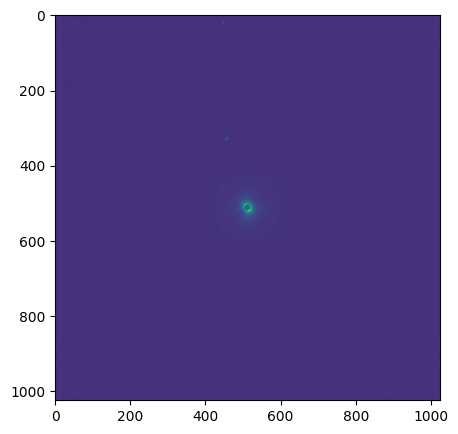

In [170]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(cube[0, 0])

In [53]:
def modify_shape_and_center(img, shift_h=1, shift_w=1):
    # Get the height and width of the image
    height, width = img.shape[:2]

    # Increase the image size by 1 pixel
    new_height = height + shift_h
    new_width = width + shift_w

    # Create a new image with the increased size
    new_img = np.zeros((new_height, new_width))

    # Calculate the offset needed to center the original image in the new image
    x_offset = int((new_width - width) / 2)
    y_offset = int((new_height - height) / 2)

    # Copy the original image into the center of the new image
    new_img[y_offset:y_offset+height, x_offset:x_offset+width] = img

    return new_img

In [54]:
psf_even = []
for curr_psf in psf[lambda_ch]:
    psf_even.append(modify_shape_and_center(curr_psf, shift_h=1, shift_w=1)) 
psf_even = np.array(psf_even)

Text(0.5, 1.0, '(3, 65, 65)')

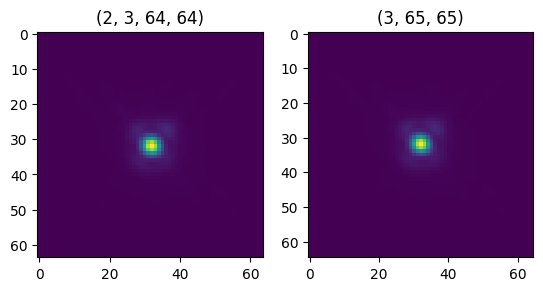

In [55]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(psf[lambda_ch, 0])
axes[0].set_title(psf.shape)

im = axes[1].imshow(psf_even[0])
axes[1].set_title(psf_even.shape)

## Check if even image size

In [134]:
from astropy.stats import gaussian_fwhm_to_sigma, gaussian_sigma_to_fwhm
from vip_hci.preproc.recentering 	import frame_shift
from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian(params, amplitude, xo, yo, sigma_x, sigma_y):
    g = amplitude * np.exp(-((params[0]-xo)**2/(2*sigma_x**2) + (params[1]-yo)**2/(2*sigma_y**2)))
    return g.ravel()

In [149]:
single_psf = psf_even[0]
x, y = single_psf.shape[0]//2, single_psf.shape[1]//2
std_x, std_y = np.std(single_psf[:, 0]), np.std(single_psf[:, 1])

initial_guess = [np.max(single_psf), x, y, std_x, std_y]

n_cols = single_psf.shape[0]
n_rows = single_psf.shape[1]
X, Y = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
fwhm_sphere = np.mean([fwhm_x, fwhm_y])

psf_norm, fwhm_flux, fwhm = normalize_psf(centered_psf, 
                                          fwhm=fwhm_sphere,
                                          full_output=True, 
                                          verbose=False) 
popt, pcov = curve_fit(gaussian, (X,Y), single_psf.ravel(), p0=initial_guess)

# Extract the parameters from the fitted model
amplitude, xo, yo, sigma_x, sigma_y = popt
fwhm_x = sigma_x*gaussian_sigma_to_fwhm
fwhm_y = sigma_y*gaussian_sigma_to_fwhm
 
# Shift PSF frame to match exactly the center of the gaussian 
shift_x = x - xo
shift_y = y - yo
centered_psf = frame_shift(single_psf, shift_y, shift_x, 
                           imlib='vip-fft', # does a fourier shift operation
                           interpolation='lanczos4', # Lanczos
                           border_mode='reflect') # input extended by reflecting about the edge of the last pixel.

# Normalize PSF
fwhm_sphere = np.mean([fwhm_x, fwhm_y])
psf_norm, fwhm_flux, fwhm = normalize_psf(centered_psf, 
                                          fwhm=fwhm_sphere,
                                          full_output=True, 
                                          verbose=False) 

## Angular Differential Imaging (ADI)

In [150]:
from sklearn.decomposition import PCA

In [151]:
pca_model = PCA(n_components=1)

In [157]:
n_frames, width, height = cube[0].shape
cube_pca = np.reshape(cube[0], [n_frames, width*height])
cube_pca.shape, cube[0].shape

((80, 1048576), (80, 1024, 1024))

In [159]:
x_transformed = pca_model.fit_transform(cube_pca)

In [160]:
x_reconstructed = pca_model.inverse_transform(x_transformed)

In [162]:
cube_reconstructed = np.reshape(x_reconstructed, [n_frames, width, height])

In [ ]:
from scipy.ndimage import rotate

In [11]:
from pca import reduce_pca_opt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
%%time
if len(cube.shape) > 3:
    cube_pca = cube[lambda_ch]
else:
    cube_pca = cube
    
adi_frame, res_cube = reduce_pca(cube_pca, rot_angles, ncomp=1, 
                             fwhm=4, return_cube=True, 
                             plot=False, dpi=100, n_jobs=8)


# frame_pca, res_cube = reduce_pca_opt(cube_pca, rot_angles, ncomp=1, 
#                              fwhm=4, return_cube=True, 
#                              plot=False, dpi=100, n_jobs=8)

CPU times: user 970 ms, sys: 146 ms, total: 1.12 s
Wall time: 404 ms


## Detection

In [128]:
table = get_intersting_coords(adi_frame, psf_norm, fwhm=fwhm, bkg_sigma=5)
table = table[table['snr'] > 2.]
print(table)

           x          y      flux  fwhm_mean       snr
0  90.673543  87.139237  3.873217    3.99179  2.582123


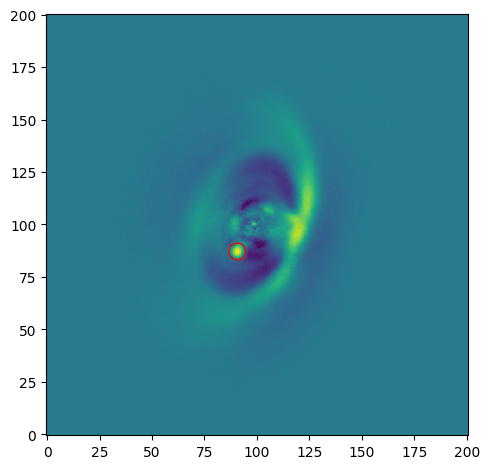

In [129]:
fig, ax = plt.subplots(1,1, dpi=100)
ax.imshow(adi_frame, origin="lower")
for _, row in table.iterrows():
    circle = plt.Circle((row['x'], row['y']), row['fwhm_mean'], fill=False, edgecolor='r')  
    ax.add_patch(circle)
fig.tight_layout()
plt.show()

In [139]:
cube[0].shape
rot_angles.shape

(90,)

In [146]:
from detection import optimize_params
cube_fake, fluxes, coords = optimize_params(table, 
                                            cube[0], 
                                            psf_norm, 
                                            fwhm_sphere, 
                                            rot_angles, 
                                            full_output=True,
                                            pixel_scale=0.01225)

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
[INFO] Optimizing companion located at (-9.33, -12.86) with flux 3.87


Processing frame 89: 100%|███████| 90/90 [00:48<00:00,  1.85it/s]


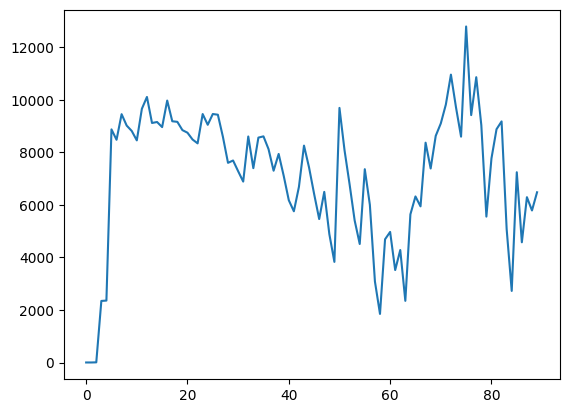

In [170]:
plt.plot(fluxes)

In [167]:
x_cube_center, y_cube_center = frame_center(cube[0])
x = coords[0] - x_cube_center
y = coords[1] - y_cube_center
radius = np.sqrt(x**2+y**2) # radius
angle  = np.arctan2(y, x)   # radians
angle  = angle/np.pi*180    # degrees
# Since atan2 return angles in between [0, 180] and [-180, 0],
# we convert the angle to refers a system of 360 degrees
theta0 = np.mod(angle, 360) 
            
frame_fake = cube_inject_companions(cube[0], 
                                    psf_norm, 
                                    rot_angles, 
                                    np.mean(fluxes), 
                                    radius,
                                    plsc=None, 
                                    n_branches=1, 
                                    theta=theta, 
                                    imlib='vip-fft',
                                    interpolation='lanczos4', 
                                    transmission=None,
                                    radial_gradient=False, 
                                    full_output=False,
                                    verbose=False, 
                                    nproc=1)

In [168]:
adi_frame_fake, res_cube = reduce_pca(frame_fake, 
                                      rot_angles, 
                                      ncomp=1, 
                                      fwhm=4, 
                                      return_cube=True, 
                                      n_jobs=8)

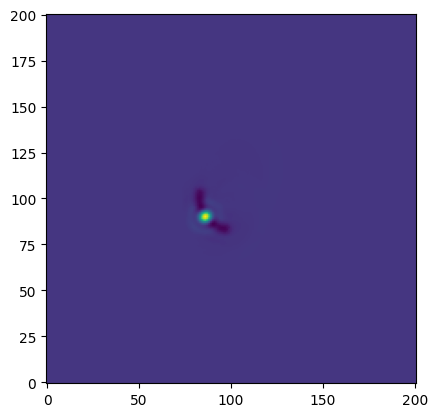

In [169]:
plt.imshow(adi_frame_fake, origin="lower")

In [15]:
table  = table.sort_values('snr')
x_comp = table.iloc[0]['x']
y_comp = table.iloc[0]['y']
gflux  = table.iloc[0]['flux']

In [16]:
from vip_hci.fm.fakecomp import cube_inject_companions
from skimage.draw import disk


In [94]:
x_cube_center, y_cube_center = frame_center(cube[0])

x = float(x_comp) - x_cube_center
y = float(y_comp) - y_cube_center

radius = np.sqrt(x**2+y**2) # radius
angle  = np.arctan2(x, y)   # radians
angle  = angle/np.pi*180    # degrees

# Since atan2 return angles in between [0, 180] and [-180, 0],
# we convert the angle to refers a system of 360 degrees
theta = np.mod(angle, 360) 


frame_fake = cube_inject_companions(cube[0], 
                                    psf_norm, 
                                    rot_angles, 
                                    -gflux, 
                                    radius,
                                    plsc=None, 
                                    n_branches=1, 
                                    theta=theta, 
                                    imlib='vip-fft',
                                    interpolation='lanczos4', 
                                    transmission=None,
                                    radial_gradient=False, 
                                    full_output=False,
                                    verbose=False, 
                                    nproc=1)

adi_frame_fake, res_cube = reduce_pca(frame_fake, 
                                      rot_angles, 
                                      ncomp=1, 
                                      fwhm=gflux, 
                                      return_cube=True, 
                                      n_jobs=8)

In [95]:
centy_fr, centx_fr = frame_center(adi_frame_fake)

posy = radius * np.sin(np.deg2rad(theta)) + centy_fr
posx = radius * np.cos(np.deg2rad(theta)) + centx_fr

indices = disk((posy, posx), radius=4)
yy, xx = indices
values = adi_frame_fake[yy, xx].ravel()    

In [96]:
frame_to_opt = np.zeros_like(adi_frame_fake)
for x in range(frame_to_opt.shape[0]):
    for y in range(frame_to_opt.shape[1]):
        if x in xx and y in yy:
            frame_to_opt[x, y] = adi_frame_fake[x, y]

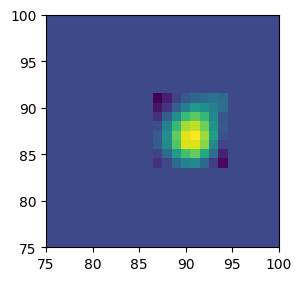

In [97]:
plt.figure(figsize=(3,5))
plt.imshow(frame_to_opt)
plt.ylim(75, 100)
plt.xlim(75, 100)
plt.show()

In [98]:
values = values[values != 0]

In [99]:
import emcee

def lnlike(flux, frame_fake, rot_angles, radius, theta):
    adi_frame_fake, res_cube = reduce_pca(frame_fake, 
                                          rot_angles, 
                                          ncomp=1, 
                                          fwhm=flux, 
                                          return_cube=True, 
                                          n_jobs=8)
    
    centy_fr, centx_fr = frame_center(adi_frame_fake)

    posy = radius * np.sin(np.deg2rad(theta)) + centy_fr
    posx = radius * np.cos(np.deg2rad(theta)) + centx_fr

    indices = disk((posy, posx), radius=4)
    yy, xx = indices
    values = adi_frame_fake[yy, xx].ravel()    
    values = values[values!=0.]
    return -np.std(values)

# Define the prior function
def lnprior(flux):
    if 1 < flux: # Prior bounds on the flux
        return 0.0
    else:
        return -np.inf
    
# Define the posterior function
def lnprob(flux, frame_fake, rot_angles, radius, theta):
    flux = np.squeeze(flux)
    lp = lnprior(flux)
    lk = lnlike(flux, frame_fake, rot_angles, radius, theta)
    return lp + lk

In [102]:
ndim, nwalkers = 1, 100
p0 = np.random.normal(loc=gflux, scale=.1, size=(nwalkers, 1))

In [103]:
from multiprocessing import Pool
nsteps = 20
# with Pool() as pool:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=[frame_fake, rot_angles, radius, theta])
out = sampler.run_mcmc(p0, nsteps, progress=True)

100%|████████████████████████████| 20/20 [16:55<00:00, 50.76s/it]


In [105]:
samples = sampler.get_chain(discard=5, flat=True)

In [106]:
flux_median = np.median(samples)
flux_err = np.percentile(samples, [16, 84]) - flux_median
gflux, flux_err, flux_median

(3.873217251043832, array([-1.21651995,  1.93247355]), 3.985808769872187)

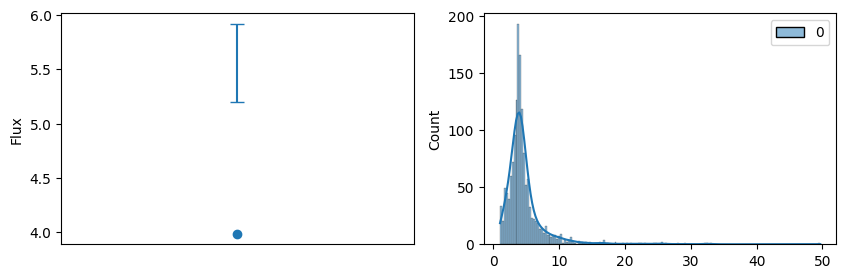

In [107]:
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].errorbar(x=0, y=flux_median, yerr=flux_err.reshape((2, 1)), fmt='o', capsize=5)
axes[0].set_xticks([])
axes[0].set_ylabel('Flux')

sns.histplot(samples, ax=axes[1], kde=True)
plt.show()

Injecting fake companion

In [110]:
frame_fake_final = cube_inject_companions(cube[0], psf_norm, rot_angles, -flux_median*20, radius,
                                    plsc=None, n_branches=1, theta=theta, imlib='vip-fft',
                                    interpolation='lanczos4', transmission=None,
                                    radial_gradient=False, full_output=False,
                                    verbose=False, nproc=1)

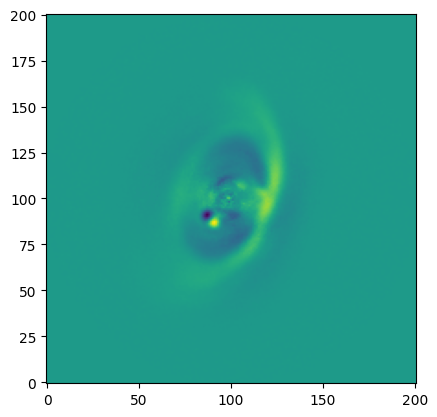

In [111]:
frame_2 = reduce_pca(frame_fake_final, 
                       rot_angles, 
                       ncomp=1, 
                       fwhm=4, 
                       n_jobs=8)

plt.imshow(frame_2, origin='lower')

Speed tricks:
- set ``imlib='opencv'`` (much faster image rotations, BUT at the expense
  of flux conservation);
- increase ``nproc`` (if your machine allows);
- reduce ``ac_c`` (or increase ``rhat_threshold`` if ``conv_test='gb'``) 
  for a faster convergence);
- reduce ``niteration_limit`` to force the sampler to stop even if it 
  has not reached convergence.

## Crop and mask cube 

In [21]:
from plottools import create_circular_mask

In [22]:
if len(cube.shape) <= 3:
    cube = cube[None, :]

In [23]:
ceny, cenx = frame_center(cube[0, 0])
imside = cube[0, 0].shape[0]
try:
    lambda_val = lambdas_inf[0]
except:
    lambda_val = 3
    
cropsize = int(lambda_val*30)

cube_crop = []
mask_crop = []
for frame in cube[0]:
    sub_im, suby, subx = get_square(frame[1:, 1:], 
                                    min(cropsize, imside),
                                    ceny, cenx, 
                                    position=True, 
                                    verbose=False)
    w, h = sub_im.shape
    sub_mask = create_circular_mask(h=h, w=w,
                                    center=frame_center(sub_im), 
                                    radius=3*lambda_val)
    
    cube_crop.append(sub_im)
    mask_crop.append(1.-sub_mask)
    
cube_crop = np.array(cube_crop)
mask_crop = np.array(mask_crop)

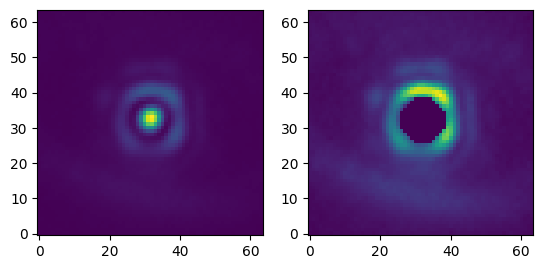

In [24]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cube_crop[0],  origin="lower")
axes[1].imshow(cube_crop[0]*mask_crop[0],  origin="lower")

We adjust the initial values to be consistent with the cropped image

In [66]:
init_values_crop = [init_values[0]- suby, init_values[1]- subx, init_values[2]]

In [67]:
np.min(psf_norm), np.max(psf_norm)

(-5.346229345750824e-05, 0.06817923814387175)

In [134]:
%%time
mcmc_output = mcmc_negfc_sampling(cube_crop, 
                                  rot_angles, 
                                  psf_norm, 
                                  init_values_crop, 
                                  imlib='opencv',
                                  niteration_limit=1000,
                                  nwalkers=10,
                                  nproc=8)

CPU times: user 9.38 s, sys: 4.68 s, total: 14.1 s
Wall time: 3min 29s


We should decide from what iteration the sampler converge to the real distribution 

In [173]:
mcmc_output.shape

(10, 1000, 3)

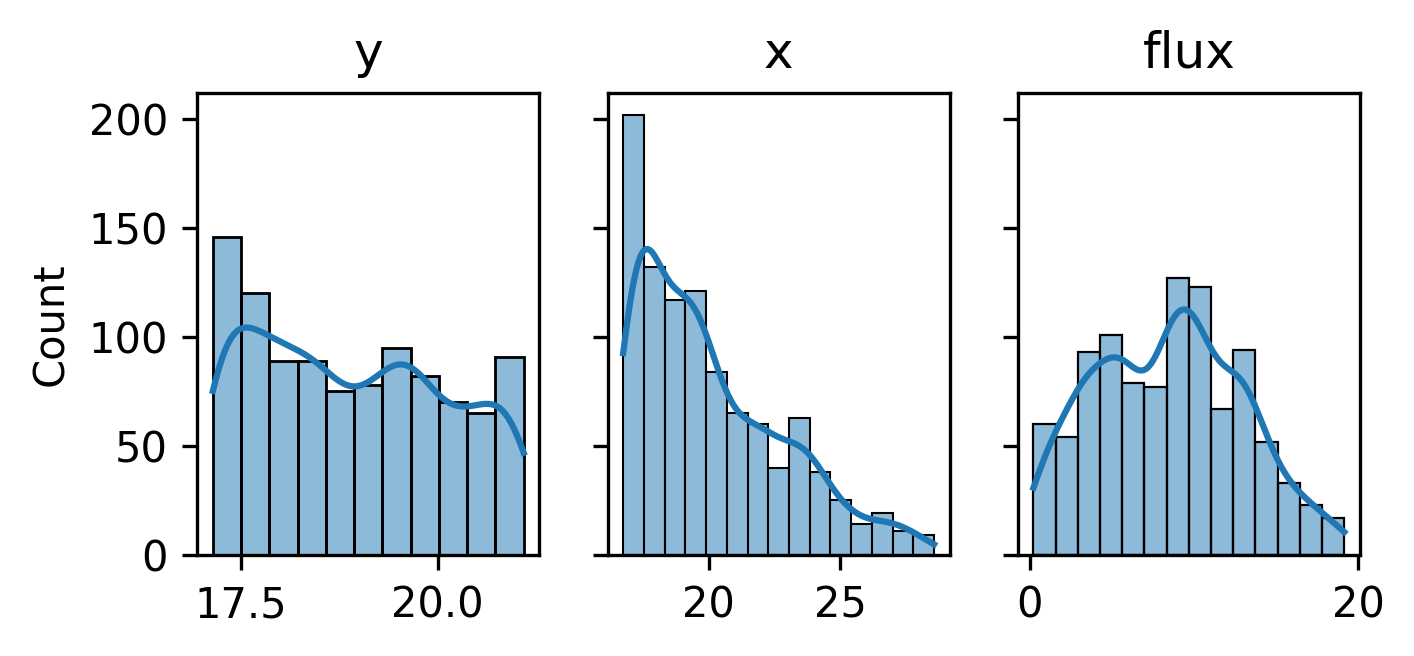

In [175]:
selected_out = mcmc_output[:, 900:, :]
out_size = selected_out.shape
out = np.reshape(selected_out, [out_size[0]*out_size[1], out_size[2]])

fig, axes = plt.subplots(1,3, figsize=(5,2), sharey=True, dpi=300)

name_params = ['y', 'x', 'flux']
for index, ax in enumerate(axes.flatten()):
    sns.histplot(out[:, index], ax=ax, kde=True)
    ax.set_title(name_params[index])

plt.show()




Now we are going to use the final values to inject a fake companion and use PCA visualize if the companion was deleted

In [176]:
y_star, x_star, flux_star = np.mean(np.mean(mcmc_output, axis=0), axis=0)
print(init_values_crop[-1], flux_star)

x_star = init_values_crop[0]
y_star = init_values_crop[1]
# flux_star = init_values_crop[2]

y_star += suby # go back to the original dimension 
x_star += subx # go back to the original dimension

3.873217251043832 8.0843751592828


In [177]:
x_cube_center, y_cube_center = frame_center(cube[0])
x = float(x_star) - x_cube_center
y = float(y_star) - y_cube_center
radius = np.sqrt(x**2+y**2) # radius
angle  = np.arctan2(x, y)   # radians
angle  = angle/np.pi*180    # degrees
# Since atan2 return angles in between [0, 180] and [-180, 0],
# we convert the angle to refers a system of 360 degrees
theta = np.mod(angle, 360) 

In [182]:
# from vip_hci.fm.fakecomp import cube_inject_companions
# frame_fake = cube_inject_companions(cube[0], psf_norm, -rot_angles, flux_star, radius,
#                                     plsc=None, n_branches=1, theta=theta, imlib='vip-fft',
#                                     interpolation='lanczos4', transmission=None,
#                                     radial_gradient=False, full_output=False,
#                                     verbose=False, nproc=1)

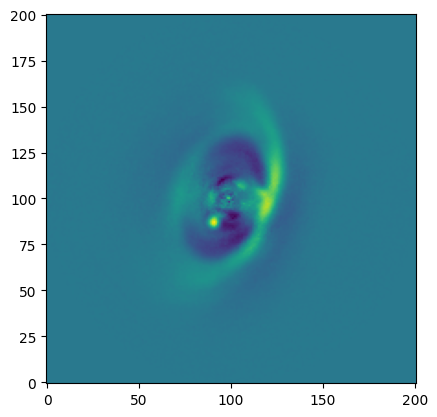

In [183]:
frame_2, res_cube = reduce_pca(frame_fake, 
                               rot_angles, 
                               ncomp=1, 
                               fwhm=4, 
                               return_cube=True, 
                               n_jobs=8)

plt.imshow(frame_2, origin='lower')

(90, 201, 201)

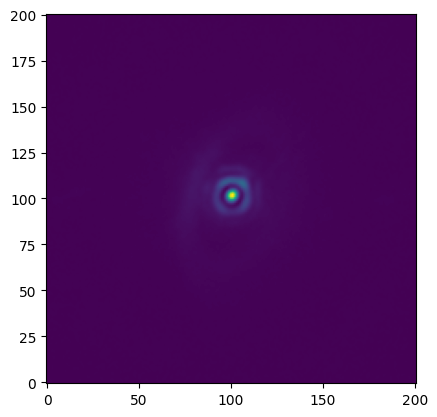

In [186]:
negfc_cube = []
for i, frame in enumerate(cube[0]):
    blank = np.zeros_like(frame)
    radius = np.sqrt(x**2+y**2) # radius
    angle  = np.arctan2(x, y)   # radians
    angle  = angle/np.pi*180    # degrees
    # Since atan2 return angles in between [0, 180] and [-180, 0],
    # we convert the angle to refers a system of 360 degrees
    theta = np.mod(angle, 360) 
    params = (radius, theta, flux_star)
            
    frame_negfc = inject_fcs_cube_mod(blank, 
                                  psf_norm, 
                                  rot_angles[i], 
                                  flux_star, 
                                  radius, 
                                  theta, 
                                  n_branches=1)   
    
    plt.imshow(frame-frame_negfc, origin='lower')
    plt.imshow(frame, origin='lower', alpha=.8)

    negfc_cube.append(frame_negfc)
negfc_cube = np.array(negfc_cube)
negfc_cube.shape

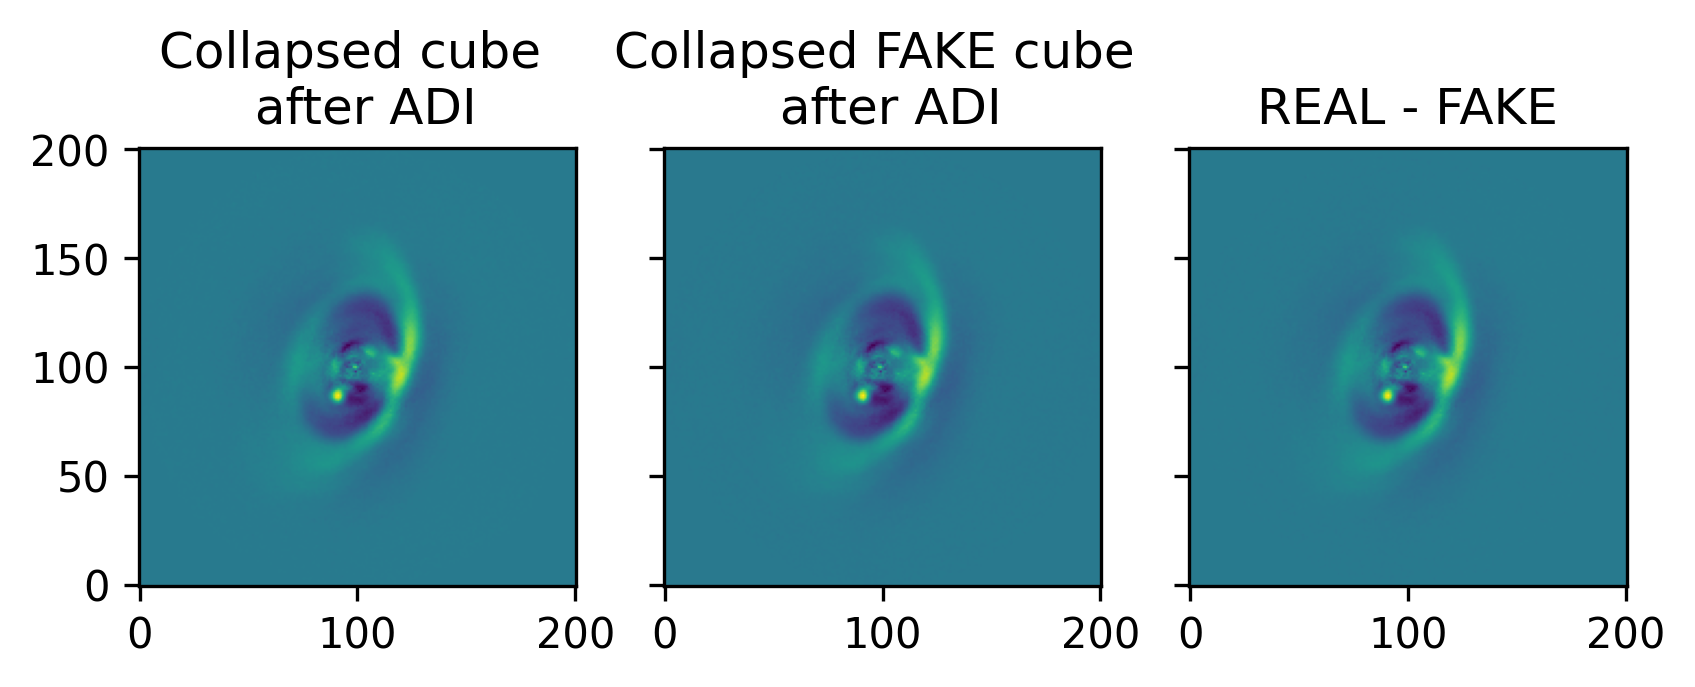

In [187]:
fig, axes = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True)
axes[0].imshow(frame_pca, origin = "lower", label='original')
axes[0].set_title('Collapsed cube \n after ADI')
axes[1].imshow(frame_2, origin = "lower", label='negfc_pca')
axes[1].set_title('Collapsed FAKE cube \n after ADI')
axes[2].imshow(frame_pca+frame_2, origin = "lower", label='residuals')
axes[2].set_title('REAL - FAKE')
plt.show()

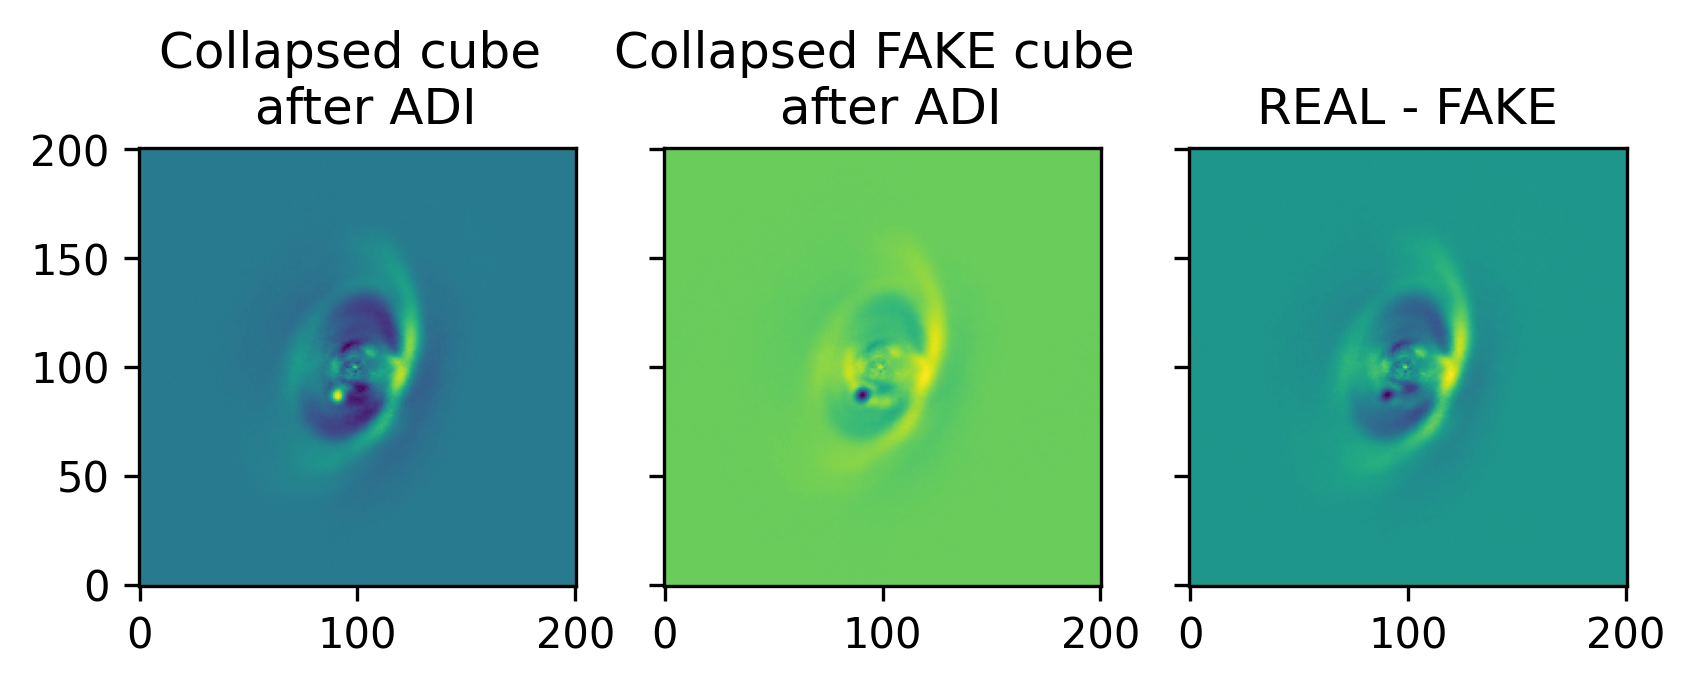

In [147]:
fig, axes = plt.subplots(1, 3, dpi=300, sharex=True, sharey=True)
axes[0].imshow(frame_pca, origin = "lower", label='original')
axes[0].set_title('Collapsed cube \n after ADI')
axes[1].imshow(frame_2, origin = "lower", label='negfc_pca')
axes[1].set_title('Collapsed FAKE cube \n after ADI')
axes[2].imshow(frame_pca+frame_2, origin = "lower", label='residuals')
axes[2].set_title('REAL - FAKE')
plt.show()